# Traccia
Analisi e Classificazione delle Email per la Rilevazione di SPAM
ProfessionAI, azienda specializzata nell'automazione basata sull'Intelligenza Artificiale, vuole sviluppare una libreria software in grado di analizzare e classificare le email ricevute. L'obiettivo principale è identificare le email di tipo SPAM per condurre successivamente delle analisi approfondite sui contenuti.

Il CEO ha espresso l'esigenza di focalizzarsi su email SPAM per comprendere meglio le tendenze, i contenuti e i comportamenti associati. Queste informazioni verranno utilizzate per migliorare la sicurezza delle comunicazioni aziendali e perfezionare i filtri anti-spam.

Obiettivi del Progetto
Il CTO ha fornito un dataset di email per realizzare le seguenti attività:

- Addestrare un classificatore per identificare le email SPAM.
- Individuare i Topic principali tra le email classificate come SPAM.
- Calcolare la distanza semantica tra i topics ottenuti per valutare l'eterogeneità dei contenuti delle email SPAM.
- Estrarre dalle email NON SPAM le informazioni sulle Organizzazioni menzionate.

Valore Aggiunto
L'analisi delle email permette a ProfessionAI di ottenere diversi vantaggi strategici:
- Miglioramento del filtro anti-spam: Un classificatore efficiente permette di ridurre significativamente il volume di email indesiderate che raggiungono la casella di posta, ottimizzando la gestione delle comunicazioni aziendali.
- Analisi contenutistica approfondita: L'individuazione dei principali topic trattati nelle email SPAM consente di ottenere informazioni preziose sui trend, tematiche e schemi ricorrenti, potenziando le strategie di cybersecurity.
- Valutazione dell'eterogeneità: La distanza semantica tra i topic consente di comprendere la diversità dei contenuti SPAM, utile per ottimizzare le difese contro un'ampia gamma di attacchi.
- Identificazione di organizzazioni: L'estrazione di organizzazioni dalle email legittime può essere sfruttata per migliorare i processi di business intelligence e gestire meglio le comunicazioni con clienti e partner.

Conclusione
Il progetto offrirà a ProfessionAI un'analisi completa delle email ricevute, con particolare focus sull'identificazione delle email SPAM e l'analisi dei loro contenuti. Grazie alla segmentazione dei topic e all'analisi semantica, l'azienda potrà migliorare significativamente i propri filtri anti-spam e ottenere insight sui contenuti di maggiore rilevanza, nonché ottimizzare la gestione delle comunicazioni aziendali tramite l'estrazione di informazioni chiave dalle email legittime.

Questa soluzione incrementerà la sicurezza delle comunicazioni e migliorerà i processi decisionali aziendali, generando un vantaggio competitivo nel settore.

Dataset
Scarica il dataset: https://github.com/ProfAI/natural-language-processing/tree/main/datasets/Verifica%20Finale%20-%20Spam%20Detection

# Svolgimento

## Librerie

In [42]:
import pandas as pd
import numpy as np
import regex as re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from seaborn import heatmap

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
import gensim.downloader as downloader

## Funzioni utili

In [43]:
# Method to sample random email from dataset and print them to check text features to be cleaned

def text_sample(texts, sample_size):
    rand_indexes = np.random.randint(0, len(texts), size=sample_size)
    for index in rand_indexes:
        print(texts.iloc[index]+"\n")

In [44]:
# Method to clean texts using regex

def regex_cleaner(texts):
    cleaned_texts = []
    for doc in texts:
        cleaned_doc = re.sub(r'Subject', '', doc, flags=re.IGNORECASE)
        cleaned_doc = re.sub(r'\s+', ' ', cleaned_doc)
        cleaned_texts.append(cleaned_doc)

    return cleaned_texts


In [45]:
# Method spacy based to clean text and lemmatize it

def spacy_cleaner(texts, pipeline):
    cleaned_texts = []
    for doc in pipeline.pipe(texts, batch_size=100, disable=['parser', 'ner']):
        tokens = [token.lemma_.lower() for token in doc if not (
            token.is_stop or
            token.is_punct or
            token.is_digit or
            token.is_space
        )]
        cleaned_doc = ' '.join(tokens)
        cleaned_texts.append(cleaned_doc)

    return cleaned_texts


In [46]:
# Method to get metrics from model

def get_metrics(model, X_train, X_test, y_train, y_test, thresh:float):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    y_train_pred = np.where(y_train_proba > thresh, 1, 0)
    y_test_pred = np.where(y_test_proba > thresh, 1, 0)

    print(f'Accuracy Train: {accuracy_score(y_train, y_train_pred): .2f}, Accuracy Test: {accuracy_score(y_test, y_test_pred): .2f}')
    print(f'Precision Train: {precision_score(y_train, y_train_pred):.2f}, Precision Test: {precision_score(y_test, y_test_pred):.2f}')
    print(f'Recall Train: {recall_score(y_train, y_train_pred):.2f}, Recall Test: {recall_score(y_test, y_test_pred):.2f}')
    print(f'F1 Train: {f1_score(y_train, y_train_pred):.2f}, F1 Test: {f1_score(y_test, y_test_pred):.2f}')
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))



In [47]:
# Method to plot precision vs recall for classification model, to spot the best probability threshold

def precision_eval(model, X_test, y_test, best):
    precision = []
    recall = []
    threshs = np.arange(0, 1, 0.1)
    lim_09 = [0.9]*threshs.shape[0]
    lim_095 = [0.95]*threshs.shape[0]
    for thresh in threshs:
        y_test_proba = model.predict_proba(X_test)[:, 1]
        y_test_pred = np.where(y_test_proba > thresh, 1, 0)
        prec = precision_score(y_test, y_test_pred)
        rec = recall_score(y_test, y_test_pred)
        precision.append(prec)
        recall.append(rec)

    plt.plot(threshs, precision, label='Precision')
    plt.plot(threshs, recall, label='Recall')
    plt.plot(threshs, lim_09, label='0.9 Threshold', linestyle='--', color='r')
    plt.plot(threshs, lim_095, label='0.95 Threshold', linestyle='--', color='g')
    plt.vlines(best, ymin=0, ymax=1, color='k', linestyle='-')
    plt.xticks(ticks=threshs)
    plt.xlabel('Threshold')
    plt.ylabel('Metrics')
    plt.title('Precision vs Recall on test set')
    plt.legend()
    plt.tight_layout()

In [48]:
# Method to identify the best number of topics for LDA based on Coherence score

def coherenc_plot(bow, dictionary, max_topics:int, passes:int, coherence_texts):
    coherence = []

    for topic in range(2, max_topics+1):
        lda = LdaMulticore(corpus=bow,
                       id2word=dictionary,
                       num_topics=topic,
                       passes=passes,
                           random_state=42,)
        coherence_lda = CoherenceModel(model=lda,
                                       dictionary=dictionary,
                                       coherence = 'c_v',
                                       texts=coherence_texts)
        coherence.append(coherence_lda.get_coherence())

    plt.plot(range(2, max_topics + 1), coherence)
    plt.xticks(range(2, max_topics + 1))
    plt.xlabel('Topic Number')
    plt.ylabel('Coherence Score')
    plt.title('Coherence Score vs Topic Number')
    plt.tight_layout()

    return coherence

In [49]:
# Method to compute topic vectors

def vectorize_topics(lda_model, embed_model):
    topic_vectors = []
    for tpc in range(len(lda_model.print_topics())):
        words = []
        weights = []
        for word in range(len(lda_model.show_topic(tpc))):
            words.append(lda_model.show_topic(tpc)[word][0])
            weights.append(lda_model.show_topic(tpc)[word][1])

        mean_vec = embed_model.get_mean_vector(words, weights)
        topic_vectors.append(mean_vec)

    topic_vectors = np.array(topic_vectors)
    return topic_vectors


In [50]:
# Method to plot diagonal topic similarities matrix

def similarities_matrix(topics_vecs, embed_model, cmap:str, labels:list):
    similarities = []
    for topic in range(topics_vecs.shape[0]):
        similarity = embed_model.cosine_similarities(topics_vecs[topic], topics_vecs)
        similarities.append(similarity)

    similarities = np.array(similarities)
    heat = heatmap(similarities, annot=True, linewidths=.05, cmap=cmap, xticklabels=labels, yticklabels=labels)
    heat.xaxis.tick_top()
    plt.xticks(rotation=45, ha='left')
    plt.title('Similarities heatmap for every topic')
    plt.tight_layout()


    return similarities


In [51]:
# Method to extract target entity from texts

def custom_ner(texts, track_entity:str, blacklist:list, noise:list, groups:dict):
    companies = []
    for doc in nlp.pipe(texts, batch_size=50):
        for entity in doc.ents:
            if entity.label_ == track_entity and entity.text not in blacklist and len(entity.text) > 1:
                companies.append(entity.text)

    companies = pd.Series(companies)

    companies_cleaned = companies.apply(lambda x: x.split('/')[-1].strip() if '/' in x else x) # takes companies names at the end of signatures
    companies_cleaned = companies_cleaned[~companies_cleaned.str.lower().isin(noise)] # if signature doesn't end up with company name but location, cleans locations

    def collapse_names(text):
        lower_text = text.lower()
        for key, final_name in groups.items():
            if key in lower_text:
                return final_name
        return text.title()

    companies_cleaned = companies_cleaned.apply(collapse_names)

    companies_cleaned = companies_cleaned[companies_cleaned.str.strip() != ""] # cleans signatures ending with blank space after last '/'

    return companies_cleaned

In [52]:
# Method to plot to "x" mentioned companies

def plot_top_org(companies, top:int):
    companies_counts = companies.value_counts()

    plt.figure(figsize = (12,6))
    sns.set_theme(style="whitegrid")
    sns.barplot(hue=companies_counts.head(top).index, x=companies_counts.head(top).values, palette='flare')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {top} Companies', fontsize=18, fontweight='bold', pad=20)
    plt.ylabel('Companies')
    plt.xlabel('Occurrences')
    plt.tight_layout()
    plt.show()

    return companies_counts

## Caricamento ed esplorazione del dataset

In questa fase si carica il dataset e lo si esplora per comprendere la sua struttura e la natura dei dati in esso contenuti

In [53]:
URL = 'https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv'

In [54]:
dataset = pd.read_csv(URL)

In [55]:
dataset.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [56]:
dataset['Unnamed: 0'].value_counts().max()

1

In [57]:
dataset = dataset.drop(['Unnamed: 0', 'label'], axis=1)
dataset

,text,label_num
0,Subject: enron methanol ; meter # : 988291\nth...,0
1,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\nthis deal is to ...,0
...,...,...
5166,Subject: put the 10 on the ft\nthe transport v...,0
5167,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
5168,Subject: calpine daily gas nomination\n>\n>\nj...,0
5169,Subject: industrial worksheets for august 2000...,0


In [58]:
dataset['label_num'].value_counts()

label_num
0    3672
1    1499
Name: count, dtype: int64

Il dataset, come era lecito attendersi, si presenta sbilanciato sulla classe ham. Dal momento però che:
- per bilanciare dovremmo fare un downsampling di più di 2000 mail su un dataset che ne ha poco più di 5000
- lo sbilanciamento non è fortissimo

Si procederà con il dataset come è, privilegiando il mantenimento dell'informazione che si perderebbe eliminando quasi la metà delle mail nel dataset. Si valuterà se bilanciare o meno sulla base delle performance del modello di classificazione.

Si passa ora all'ispezione del testo delle email al fine di identificare eventuali schemi di caratteri o parole che rappresentano "sporcizia" sistematica che è possibile eliminare in fase di pulizia.

In [59]:
text_sample(dataset['text'], 10)

Subject: teco fronterra - here it is
- - - - - - - - - - - - - - - - - - - - - - forwarded by janet h wallis / hou / ect on 03 / 08 / 2001
02 : 49 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -
bruce sukaly @ enron
03 / 05 / 2001 04 : 52 pm
to : stuart zisman / hou / ect @ ect , doug gilbert - smith / corp / enron @ enron , david
portz / hou / ect @ ect , janet h wallis / hou / ect @ ect , berney c aucoin / hou / ect @ ect ,
edith cross / hou / ect @ ect , jason r wiesepape / hou / ect @ ect , michelle
parks / corp / enron @ enron
cc :
subject : teco fronterra - here it is
- - - - - - - - - - - - - - - - - - - - - - forwarded by bruce sukaly / corp / enron on 03 / 05 / 2001
04 : 50 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -
" joan johnson " on 03 / 05 / 2001 04 : 39 : 03 pm
to : , , " dan sanford "
, " eric bronner " ,
" frank busot " , " george d . jennings "
cc :
subject : draft energy management services agreement
gentlemen : attached please find the first ro

Dall'ispezione dei testi risulta chiara la presenza di parole come "Subject:" e la formattazione del testo con "\n" o "\t" che potranno essere sicuramente eliminati in fase di pulizia.

## Classificatore delle email

### Pulizia del testo

Si procede con una pulizia che elimini eventuali caratteri "a capo" o indentazione (\n, \t) e la parola "Subject" che compare in ogni documento e non ha quindi alcuna valenza semantica.

Si procede poi con la pulizia degli spazi, delle stopwords, dei segni di punteggiatura e con la lemmatizzazione delle parole.

In [60]:
nlp = spacy.load('en_core_web_sm')

In [61]:
X_clsf = spacy_cleaner(regex_cleaner(dataset['text']),nlp)

In [62]:
type(X_clsf), len(X_clsf)

(list, 5171)

In [63]:
y_clsf = dataset['label_num']

In [64]:
type(y_clsf), len(y_clsf)

(pandas.core.series.Series, 5171)

### Modello di classificazione

Seguendo un approccio incrementale, si affronta la fase di classificazione partendo da un modello semplice per poi valutare le performance e capire se passare a qualcosa di più complesso. Pertanto il modello prescelto è un modello Naive Bayes con vocabolario popolato via TFIDF.

Prima di procedere all'addestramento vero e proprio si effettuerà la Cross Validation per saggiare la tendenza dei modelli Naive Bayes all'overfitting.

Quanto alle metriche invece, si monitoreranno le classiche Accuracy, Precision, Recall e F1, con particolare attenzione alla Precision, a scapito della Recall. Si reputa infatti migliore, un modello che faccia passare più spam che un modello che blocchi mail sane.

In [65]:
X_clsf_train, X_clsf_test, y_clsf_train, y_clsf_test = train_test_split(X_clsf, y_clsf,
                                                                        test_size=0.2,
                                                                        stratify=y_clsf)


In [66]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.001)

In [67]:
X_clsf_train = tfidf.fit_transform(X_clsf_train)
X_clsf_test = tfidf.transform(X_clsf_test)

X_clsf_train.shape, X_clsf_test.shape

((4136, 5413), (1035, 5413))

In [68]:
mnb = MultinomialNB()

In [69]:
cv_results = cross_validate(mnb, X_clsf_train, y_clsf_train, cv=5, return_train_score=True, scoring='accuracy')

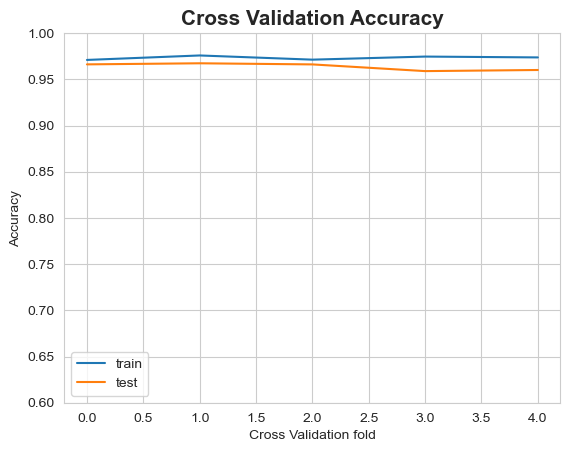

In [70]:
plt.plot(cv_results['train_score'], label='train')
plt.plot(cv_results['test_score'], label='test')
plt.legend(loc='best')
plt.xlabel('Cross Validation fold')
plt.ylabel('Accuracy')
plt.title('Cross Validation Accuracy', fontsize=15, fontweight='bold')
plt.ylim(0.6, 1)
plt.show()


La Cross Validation restituisce dei valori sul set di test leggermente inferiori rispetto all'addestramento, ma comunque sufficientemente vicini da non potersi considerare overfitting.

In [71]:
mnb.fit(X_clsf_train, y_clsf_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


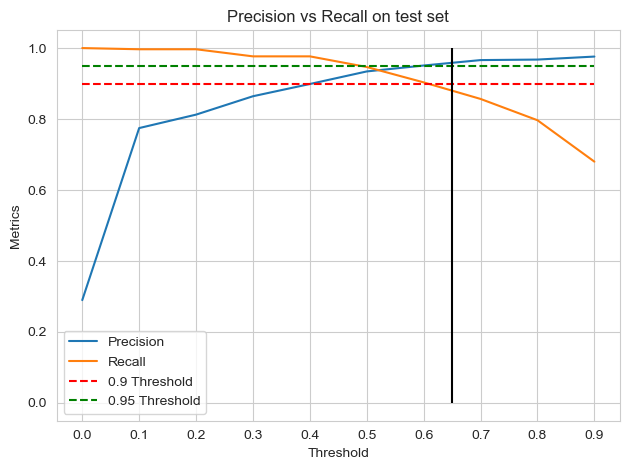

In [72]:
precision_eval(mnb, X_clsf_test, y_clsf_test, 0.65)

Grazie al grafico si nota che con una soglia per il calcolo della classe di 0.55 circa, si ha il bilanciamento tra Precision e Recall, ma dal momento che, tra le 2, si preferisce ottimizzare la Precision, a scapito della Recall, si pone la soglia a 0.65 così da mantenere comunque una Recall entro il 90%, ma una Precision a circa il 95%

In [73]:
get_metrics(mnb, X_clsf_train, X_clsf_test, y_clsf_train, y_clsf_test,0.65)

Accuracy Train:  0.97, Accuracy Test:  0.96
Precision Train: 0.96, Precision Test: 0.96
Recall Train: 0.94, Recall Test: 0.89
F1 Train: 0.95, F1 Test: 0.92
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       735
           1       0.96      0.89      0.92       300

    accuracy                           0.96      1035
   macro avg       0.96      0.94      0.94      1035
weighted avg       0.96      0.96      0.96      1035

[[723  12]
 [ 34 266]]


### Conclusioni sul classificatore

Il classificatore Naive Bayes ha mostrato ottime performance sulle email, con metriche molto valide e nessuna traccia di overfitting, nonostante gli alti valori di Accuracy sul set di addestramento.

Pertanto si ritiene il modello Naive Bayes adeguato per il compito.

## Topic modeling

In questa sezione si estraggono gli argomenti principali limitatamente alle email di spam. Si ricorrerà quindi all'algoritmo LDA, previa identificazione del numero di topics ideale. Per fare ciò si analizzerà l'andamento del Coherence Score, che valuta la pertinenza dei topic creati in base alla similarità delle principali parole in esso individuate.

Dal momento che ovviamente la coerenza varia al variare dei topic, si prenderà il numero di topic che massimizza la Coerenza

### Estrazione dataset

In [74]:
X_lda_spam = dataset.loc[dataset['label_num']==1]['text']

In [75]:
X_lda_spam_clean = spacy_cleaner(regex_cleaner(X_lda_spam), nlp)

In [76]:
X_lda_spam_clean = [doc.split() for doc in X_lda_spam_clean]

### LDA

In [77]:
dictionary = Dictionary(X_lda_spam_clean)

In [78]:
bow_lda = [dictionary.doc2bow(doc) for doc in X_lda_spam_clean]

[0.3189233967302024,
 0.3424295211533313,
 0.42143481352506595,
 0.5864349890261131,
 0.558657189271897,
 0.5734355430521835,
 0.5534617334758654,
 0.5261746173551546,
 0.5439969005153353,
 0.5400567295041515,
 0.5109629468576599,
 0.4808040791201749,
 0.4836553634635032,
 0.4655442350782234]

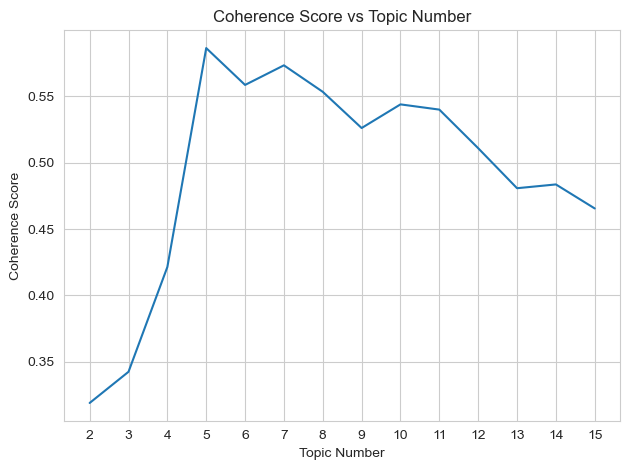

In [79]:
coherenc_plot(bow_lda, dictionary, 15, passes=10, coherence_texts=X_lda_spam_clean)

Il metodo mostra chiaramente che il numero ideale di topic che garantisce una migliore coerenza è 5. Procediamo quindi ora con l'effettiva LDA con il numero di topic individuato.

In [80]:
lda = LdaMulticore(corpus=bow_lda,
                    id2word=dictionary,
                    num_topics=5,
                    passes=10,
                    random_state=42)

### Distanza semantica tra i topic

Una volta girato il modello con il numero di topic ottimale, 5, vediamo effettivamente quali sono le principali parole identificate per ogni argomento.

In [81]:
pprint(lda.print_topics())

[(0,
  '0.065*"=" + 0.011*"font" + 0.011*"td" + 0.009*"http" + 0.008*"d" + '
  '0.008*"height" + 0.007*"width" + 0.006*"size" + 0.006*"com" + '
  '0.005*"align"'),
 (1,
  '0.010*"s" + 0.010*"com" + 0.009*"$" + 0.008*"http" + 0.006*"www" + '
  '0.006*"e" + 0.005*"nbsp" + 0.005*"price" + 0.005*"t" + 0.004*"email"'),
 (2,
  '0.002*"penis" + 0.002*"offer" + 0.002*"m" + 0.001*"money" + 0.001*"t" + '
  '0.001*"s" + 0.001*"dosage" + 0.001*"f" + 0.001*"time" + 0.001*"inch"'),
 (3,
  '0.005*"adobe" + 0.004*"window" + 0.003*"ms" + 0.003*"professional" + '
  '0.003*"office" + 0.003*"photoshop" + 0.003*"xp" + 0.002*"mx" + '
  '0.002*"software" + 0.002*"price"'),
 (4,
  '0.021*"|" + 0.016*"$" + 0.014*"company" + 0.009*"s" + 0.008*"statement" + '
  '0.007*"stock" + 0.006*"price" + 0.006*"information" + 0.005*"security" + '
  '0.005*"report"')]


Da esse è possibile riconoscere delle tematiche associate al topic che proviamo a definire di seguito

In [82]:
nomi_topic = [
    "HTML &\nTechnical Artifacts",  # Topic 0: Tag HTML e formattazione
    "Web Marketing &\nClickbait",   # Topic 1: Link HTTP e offerte commerciali
    "Pharma &\nAdult Content",      # Topic 2: Farmaci e contenuti per adulti
    "Software &\nProfessional",     # Topic 3: Adobe, Microsoft e licenze
    "Financial &\nStock Scams"      # Topic 4: Azioni, report aziendali e investimenti
]

Al fine di identificare la vicinanza dei 5 topic identificati, si procederà così:
- caricamento di un modello Word2Vec pre addestrato, glove-wiki-gigaword-300 che restituisce embedding per singola parola di dimensione 300. Questo consente di carpire pienamente il senso delle parole stesse
- Tramite un metodo dedicato, estrarre, per le prime 10 parole di ogni topic, l'embedding corrispettivo dal modello Word2Vec e farne la media pesata (con la probabilità associata a ciascuna delle 10 parole). In questo modo si avrà un unico vettore identificativo del topic
- Calcolo della cosine similarity tra i 5 topic. Ne risulta una matrice diagonale 5x5

In [83]:
downloader.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [84]:
w2v = downloader.load('glove-wiki-gigaword-300')

In [85]:
topics_vectors = vectorize_topics(lda, w2v)
topics_vectors.shape

(5, 300)

(5, 5)

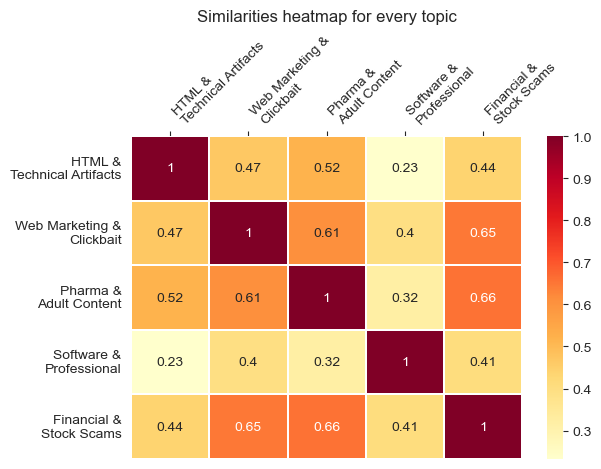

In [86]:
topic_distance = similarities_matrix(topics_vectors, w2v, 'YlOrRd', nomi_topic)
topic_distance.shape

Molto interessante il notare la vicinanza semantica tra le categorie:
- Web Marketing & Clickbait
- Pharma & Adult Content
- Financial & Stock Scams

Questo in effetti riflette a pieno il contesto dello spam e delle truffe finanziarie, noncheè del phishing.

Le email legate a software e licenze devono evidentemente adottare un gergo molto più professionale, meno pressante o urgente rispetto alle truffe. Di conseguenza presentano una sostanziale distanza rispetto a tutti gli altri argomenti.

Con tenore piuù lieve, ma lo stesso vale per il gergo tecnico e i tag html, chiaramente spam, ma non vicino alle classi piuù pericolose

## NER

In [87]:
X_ner = dataset.loc[dataset['label_num']==0]['text']

In [88]:
X_ner = regex_cleaner(X_ner)

Iterando sui dati con pulizie sempre più approfondite, si è identificato che, inizialmente con una pulizia leggera, le prime 3 organizzazioni erano A, xls e doc. Essendo queste chiaramente non organizzazioni, sono state filtrate tramite l'utilizzo di una blacklist

In [89]:
blacklist = ['A', 'xls', 'doc']

Di seguito si è notato la preponderanza di Enron, soprattutto perchè vi erano molte occorrenze 'composte' in cui non compariva semplicemente Enron, ma Enron Corp e altre permutazioni, tutte contenente il nome Enron, ma trattate dalla NER come aziende diverse. Si è pertanto fatto ricorso a un raggruppamento tramite questo dizionario

In [90]:
mapping_groups = {
        'enron': 'Enron',
        'exxon': 'Exxon',
        'pg & e': 'PG&E'
    }

In [91]:
companies = custom_ner(X_ner, track_entity='ORG', blacklist=blacklist, noise=['hou'], groups=mapping_groups)

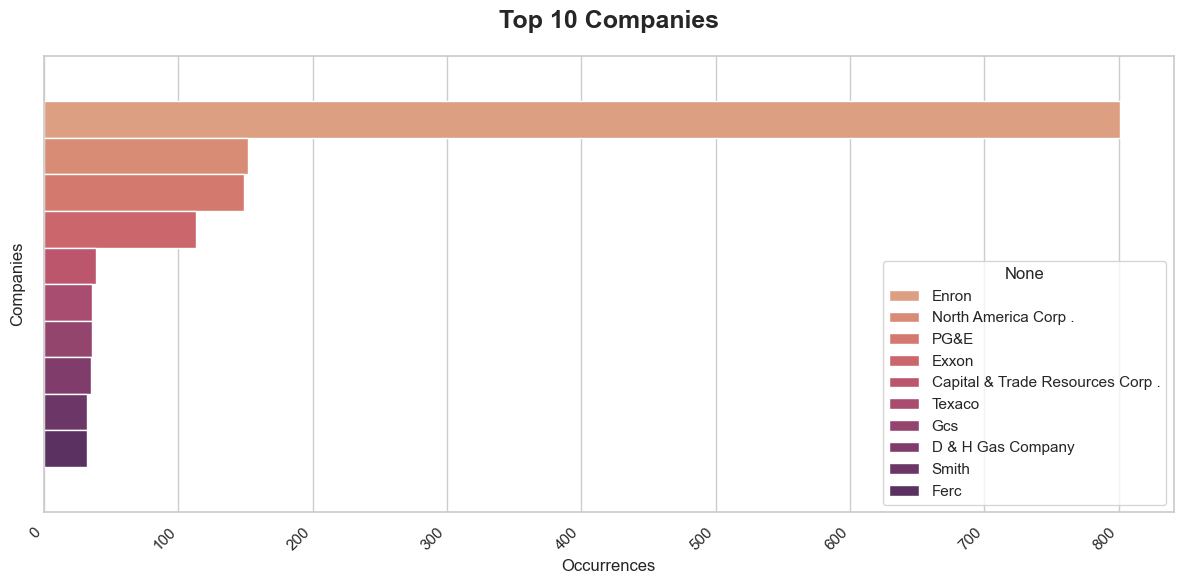

Enron                               801
North America Corp .                152
PG&E                                149
Exxon                               113
Capital & Trade Resources Corp .     39
                                   ... 
Lehman                                1
Modem Special Edition                 1
Midcon ( Kindermorgan                 1
Gpg                                   1
Md )                                  1
Name: count, Length: 904, dtype: int64

In [92]:
plot_top_org(companies, 10)

In [93]:
companies.head(30)

0                      Bearer
1          Foot Locker Canada
10                      Enron
12                       Teco
14           The Houston Expl
15                      Enron
16           The Houston Expl
17                      Enron
18                        Cst
19                      Enron
20        The Texas Gas Group
23       North America Corp .
26                      Enron
27                      Enron
28    Doc - Calpine Daily Gas
30             Cico Oil & Gas
31                     Canedy
32                  Jen Black
33                     Brenda
34                     Sutton
35                     Trisha
36          Devers @ Columbia
37             Syscom - Inc .
38                   Michelle
39                     Daniel
40                        Nyu
41                        Nyu
42              Janelle Mccan
43                Abercrombie
44                    Janelle
dtype: object

## Conclusione

Il modello può essere portato in produzione essendo sicuri che non generi overfitting e sia in grado di rintracciare con ottima accuratezza le email spam dalle ham.

Inoltre, tramite il topic modeling sul set analizzato è stato possibile individuare 5 gruppi ben specifici di email nocive e questo può facilitare la messa in atto di metodologie di protezione. In particolare eè emersa una particolare vicinanza semantica tra le truffe finanziarie e lo spam a fini di marketing e vendita.

Infine, è stato possibile identificare le 10 principali organizzazioni con le quali si intrattiene corrispondenza, mostrando una prevalenza dei contatti con la Enron.

Si consiglia quindi di valutare le performance del modello sui dati live della produzione così da proseguirne l'addestramento e monitorare sempre le email classificate come spam con il modello di LDA per verificare il sopraggiungere di nuove categorie che farebbe variare la coerenza dei 5 topic portando alla creazione di nuovi.